In [1]:
!pip install requests

In [2]:
!pip install pandas

In [2]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd

In [4]:
url = 'https://toncenter.com/api/v3/transactions'
account = 'UQBj96aEiJlFV4Si16ajonjQRHf_OOb-80WXTOOUTHxd8h0a'
api_key = 'XXXXXX'
sort = 'asc'
limit = 256
offset = 0
# 拉取数据数目 >= batch，则写入文件，避免内存超限
batch = 100000000 # 1e8

base_day_str = "2024-4-28 00:00:00"
base_day = datetime.strptime(base_day_str, '%Y-%m-%d %H:%M:%S')
start_day = base_day
# add 1 day
end_day = start_day + timedelta(days=1)

stop_day_str = "2024-5-28 00:00:00"
stop_day = datetime.strptime(stop_day_str, '%Y-%m-%d %H:%M:%S')

# UTX_TIMESTAMP
start_utime = int(start_day.timestamp()) # 1710432000
end_utime = int(end_day.timestamp()) # 1710518400
stop_utime = int(stop_day.timestamp()) # 1713974400

# 更新时间窗口：更新 start_utime & end_utime，每次更新窗口往后 + (1 day)
# 停止条件：当 end_utime 到达设定的截止时间时停止拉取数据
# 写出数据条件：if len(transactions) > batch，导出数据到 excel
# 时间窗口内拉数据方式:
#    时间窗口内第一次拉取数据，offset = 0
#    以后每一次新增则 offset += limit
#    停止条件：获取数据量 < limit

while end_utime <= stop_utime:
    print('[start_day, end_day]', '[', start_day, end_day, ']')
    offset = 0
    transactions = []
    params = {
        'account': account,
        'start_utime': start_utime,
        'end_utime': end_utime,
        'limit': limit,
        'offset': offset,
        'sort': sort,
        'api_key': api_key}
    
    response = requests.get(url, params=params)
    temp_transactions = response.json()['transactions']
    transactions.extend(temp_transactions)
    print('transactions load', '[', len(transactions) - len(temp_transactions), len(transactions), ']', 'offset', offset)
    
    while len(temp_transactions) >= limit:
        offset = offset + limit
        params = {
            'account': account,
            'start_utime': start_utime,
            'end_utime': end_utime,
            'limit': limit,
            'offset': offset,
            'sort': sort,
            'api_key': api_key}
        
        response = requests.get(url, params=params)
#         print(response.json())
        temp_transactions = response.json()['transactions']
        
        transactions.extend(temp_transactions)
        print('transactions load', '[', len(transactions) - len(temp_transactions), len(transactions), ']', 'offset', offset)
             
    
    if len(transactions) > 0:
        # 写出数据
        df = pd.json_normalize(transactions)
        # 创建一个Excel 
        with pd.ExcelWriter('./tonda.xlsx', mode='a', if_sheet_exists='replace') as writer:
            df.to_excel(writer, index=False, sheet_name=start_day.strftime('%Y-%m-%d'))
        print('save excel success')
        
    # 更新时间窗口
    start_day = start_day + timedelta(days=1)
    end_day = end_day + timedelta(days=1)
    start_utime = int(start_day.timestamp())
    end_utime = int(end_day.timestamp())

[start_day, end_day] [ 2024-04-28 00:00:00 2024-04-29 00:00:00 ]
transactions load [ 0 256 ] offset 0
transactions load [ 256 512 ] offset 256
transactions load [ 512 768 ] offset 512
transactions load [ 768 1024 ] offset 768
transactions load [ 1024 1280 ] offset 1024
transactions load [ 1280 1536 ] offset 1280
transactions load [ 1536 1792 ] offset 1536
transactions load [ 1792 2048 ] offset 1792
transactions load [ 2048 2304 ] offset 2048
transactions load [ 2304 2560 ] offset 2304
transactions load [ 2560 2816 ] offset 2560
transactions load [ 2816 3072 ] offset 2816
transactions load [ 3072 3328 ] offset 3072
transactions load [ 3328 3584 ] offset 3328
transactions load [ 3584 3840 ] offset 3584
transactions load [ 3840 4096 ] offset 3840
transactions load [ 4096 4352 ] offset 4096
transactions load [ 4352 4608 ] offset 4352
transactions load [ 4608 4864 ] offset 4608
transactions load [ 4864 5120 ] offset 4864
transactions load [ 5120 5376 ] offset 5120
transactions load [ 5376 5

KeyError: 'transactions'

In [ ]:
!ls

In [ ]:
base_day_str = "2024-4-27"
base_day = datetime.strptime(base_day_str, '%Y-%m-%d')
start_day = base_day
# add 1 day
next_day = start_day + timedelta(days=1)

stop_day_str = "2024-5-28"
stop_day = datetime.strptime(stop_day_str, '%Y-%m-%d')

# UTX_TIMESTAMP
start_utime = int(start_day.timestamp()) # 1710432000
next_utime = int(next_day.timestamp()) # 1710518400
stop_utime = int(stop_day.timestamp()) # 1713974400

sheet_name = []

while next_utime <= stop_utime:
    sheet_name.append(start_day.strftime('%Y-%m-%d'))
    
    start_day = start_day + timedelta(days=1)
    next_day = next_day + timedelta(days=1)
    start_utime = int(start_day.timestamp())
    next_utime = int(next_day.timestamp())

In [ ]:
file_path = './tonda.xlsx'

df = pd.DataFrame()

sheets = pd.ExcelFile(file_path).sheet_names

# 循环读取每个工作表的数据
for sheet in sheets:
    data = pd.read_excel(file_path, sheet_name=sheet)
    df = pd.concat([df, data], ignore_index=True)
#     all_data = all_data.append(data, ignore_index=False)

In [10]:
int(df['in_msg.created_at'][0])

1710950386

In [63]:
# 计算提现金额
# 筛选出 in_msg.created_at 为 NaN 且 out_msg.created_at 不为 NaN 的行
filtered_df = df[df['in_msg.created_at'].isna()].reset_index()

# temp = eval(filtered_df['out_msgs'][5])

# temp[0]['value']

values = [int(eval(x)[0]['value'])/1000000000 for x in filtered_df['out_msgs']]
# [datetime.utcfromtimestamp(x).date() for x in filtered_df['now']]
# df['date'] = df['in_msg.created_at'].apply(lambda x: datetime.utcfromtimestamp(x).date())

# 求和所有 TON 收入
sum(values)

335000.5

In [3]:
# 计算收入流水
filtered_df = df[~df['in_msg.created_at'].isna()].reset_index()
filtered_df['date'] = filtered_df['in_msg.created_at'].apply(lambda x: datetime.utcfromtimestamp(x).date())
# filtered_df['date']

date_df = filtered_df.groupby('date')['in_msg.value'].sum()/1000000000

In [6]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 338.9 kB/s eta 0:00:001m274.5 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.4/232.4 kB 36.7 kB/s eta 0:00:00 kB/s eta 0:00:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 332.5 kB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 761.5 kB/s eta 0:00:00 kB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 646.7 kB/s eta 0:00:001m640.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 880.1 kB/s eta 0:00:001m1.2 MB/s eta 0:00:01


In [24]:
!pip install mdates

ERROR: Could not find a version that satisfies the requirement mdates (from versions: none)
ERROR: No matching distribution found for mdates


In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [16]:
# 将 Series 转换为 DataFrame,并将索引设置为日期
date_df = pd.DataFrame({'value': date_df.values}, index=pd.to_datetime(date_df.index))

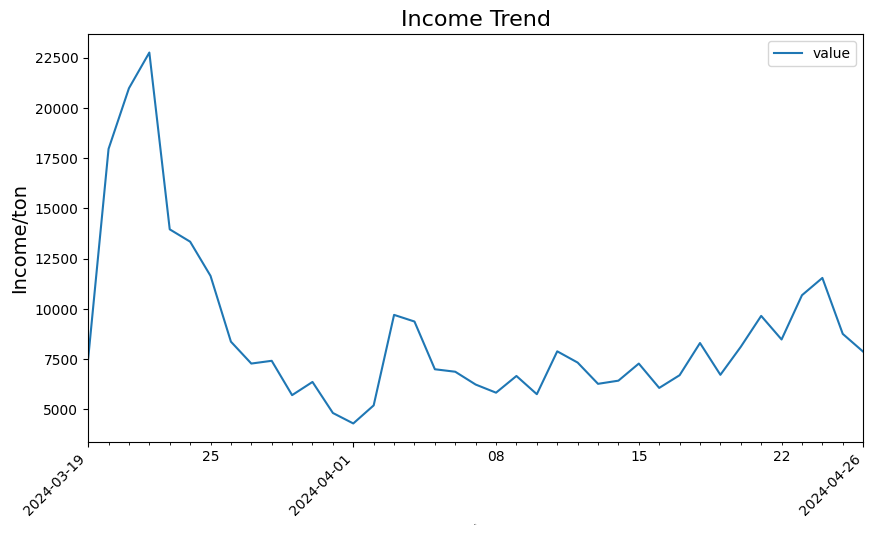

In [27]:
# 绘制折线图
# 绘制折线图
fig, ax = plt.subplots(figsize=(10, 6))
ax = date_df.plot(ax=ax)

# 设置图表标题和轴标签
plt.title('Income Trend', fontsize=16)
plt.xlabel('Date', fontsize=1)
plt.ylabel('Income/ton', fontsize=14)

# 设置日期格式
date_formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_formatter)

# 旋转日期标签,防止重叠
plt.gcf().autofmt_xdate()
fig.autofmt_xdate(rotation=45)

# 显示图表
plt.show()

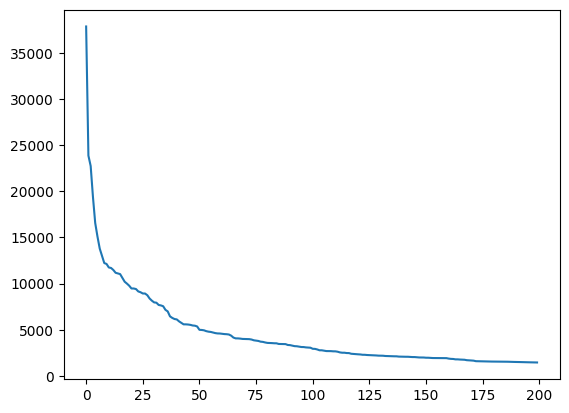

In [102]:
# 累计打款额最高的 10 个账户地址，以及 打款金额

grouped = filtered_df.groupby('in_msg.source')['in_msg.value'].sum().reset_index()

grouped['value'] = grouped['in_msg.value'].apply(lambda x: x / 100000000)


# 将 value 的和从大到小排序
grouped = grouped.sort_values(by='in_msg.value', ascending=False).reset_index()

# 取前 10 行
top_10 = grouped.head(100).reset_index()

head_group = grouped.head(200)
plt.plot(head_group.index, head_group['value'])

In [103]:
head_group['value'][199]

1465.323

In [104]:
grouped

,index,in_msg.source,in_msg.value,value
0,41359,0:64B05D30B4B92E28A23B21BB5FE4B189163B73023FFD...,3.784155e+12,3.784155e+04
1,76255,0:BA6B6A49C2C2AA9913EF03EC183A29B385342DD90B51...,2.386180e+12,2.386180e+04
2,22617,0:375999E02FE064DCAA37E2134092689C0569A7D0FF6B...,2.273454e+12,2.273454e+04
3,89526,0:DB4D2E89A4AE53CF63A03072F70908053EBB36B068EC...,1.940032e+12,1.940031e+04
4,104153,0:FEF8FF08F4352C3D6E82ECE6F626134DE61099AE41A8...,1.656604e+12,1.656604e+04
...,...,...,...,...
104572,70093,0:AB6E988E452E98EFBF95D0A6C9B6F1EFAFBF61AA16D0...,1.000000e+00,1.000000e-08
104573,64329,0:9D3BE25F2852FC61090C59602865792493B6CA91371E...,1.000000e+00,1.000000e-08
104574,38616,0:5DEC6425590EF51FDBFF8C1DCFA3F94B6D5E70901CD8...,1.000000e+00,1.000000e-08
104575,75689,0:B8F854D6CBAACDE7621E717EAA20C85EA6AFF2663500...,1.000000e+00,1.000000e-08


In [106]:
# 产品链接

product_link = 'https://shopee.ph/New-ssppor123-Cute-Japanese-Muffin-Thick-Bottom-lncreased-Cool-Slippers-add-size-i.168671225.23819978195?xptdk=6dad6f78-b802-411b-a6c7-a2c2a906de76'

In [109]:
def find_substring_between(string, start, end):
    start_index = string.find(start)
    if start_index == -1:
        return ""  # Start character not found

    end_index = string.find(end, start_index + len(start))
    if end_index == -1:
        return ""  # End character not found

    return string[start_index + len(start):end_index]

# Example usage
start_char = "i."
end_char = "?"

substring = find_substring_between(product_link, start_char, end_char)
print(substring)  # Output: " Thi"
substring.replace('.', '/')

168671225.23819978195


'168671225/23819978195'

In [143]:
# coding:utf-8
"""
Compatible for python2.x and python3.x
requirement: pip install requests
"""
from __future__ import print_function
import requests
import pandas as pd
from datetime import datetime

In [144]:
# 请求示例 url 默认请求参数已经做URL编码
url = "https://api-gw.onebound.cn/shopee/item_get/?key=t5295518250&num_iid=168671225/23819978195&country=.ph&lang=zh-CN&secret=20240502"
headers = {
    "Accept-Encoding": "gzip",
    "Connection": "close"
}
r = requests.get(url, headers=headers)
json_obj = r.json()
skus = json_obj['item']['skus']['sku']
title = json_obj['item']['title']

In [145]:
df = pd.DataFrame(columns=["date", "title", "properties_name", "price", "quantity"])

In [149]:
rows = []

for sku_info in skus:
    properties_name = sku_info["properties_name"]
    price = sku_info["price"]
    quantity = sku_info["quantity"]
    
    row = {
        "title": title,
        "date": datetime.now().date(),
        "properties_name": properties_name,
        "price": price,
        "quantity": quantity    }
    
    rows.append(row)

In [150]:
df = pd.DataFrame(rows)

In [151]:
df.to_excel('./shopee_compete_sku.xlsx')